In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from datasets import load_dataset

import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report


/home/test/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cnt = 0
# path = "/Users/bhara-zstch1566/Projects/CRM DI/Document Type Detection/Dataset"
# for i in os.listdir(path):
#     if i[0]==".":
#         continue
#     print(len(os.listdir(path+"/"+i)),i)


In [3]:
dataset = load_dataset("bharath-shanmugasundaram/Document-Type-Detection")

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [4]:
class_names = dataset["train"].features["label"].names
num_classes = len(class_names)

print(class_names)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def transform_fn(example):
    images = example["image"]

    if isinstance(images, list):
        example["image"] = [
            transform(img.convert("RGB")) for img in images
        ]
    else:
        example["image"] = transform(images.convert("RGB"))

    return example


dataset = dataset.with_transform(transform_fn)


['Bank Statement', 'Government Forms', 'Insurence', 'Invoice', 'Resume']


In [5]:
train_loader = DataLoader(
    dataset["train"],
    batch_size=16,              # 1–2 for EVA, 4 for Swin
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    drop_last=True
)
val_loader = DataLoader(
    dataset["validation"],
    batch_size=16,
    shuffle=False,             # IMPORTANT
    num_workers=8,
    pin_memory=True,
    persistent_workers=False,
    drop_last=False
)


In [6]:
model = timm.create_model("vit_7b_patch16_dinov3.lvd1689m",pretrained=True,num_classes=num_classes)

print(1)
for param in model.parameters():
    param.requires_grad = False
print(2)
for param in model.head.parameters():
    param.requires_grad = True
print(3)
for param in model.blocks[-1].parameters():
    param.requires_grad = True



1
2
3


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([{"params": model.blocks[-1].parameters(), "lr": 1e-4},{"params": model.head.parameters(), "lr": 1e-3},])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [8]:
EPOCHS = 6

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print("training",epoch)

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = (correct/total) *100

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")


/home/test/miniconda3/lib/python3.13/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 0
Epoch [1/6] | Train Loss: 0.2664 | Val Acc: 93.58%


/home/test/miniconda3/lib/python3.13/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 1
Epoch [2/6] | Train Loss: 0.1381 | Val Acc: 94.43%


/home/test/miniconda3/lib/python3.13/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 2
Epoch [3/6] | Train Loss: 0.0770 | Val Acc: 94.56%


/home/test/miniconda3/lib/python3.13/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 3
Epoch [4/6] | Train Loss: 0.0434 | Val Acc: 94.65%


/home/test/miniconda3/lib/python3.13/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 4
Epoch [5/6] | Train Loss: 0.0283 | Val Acc: 93.86%


/home/test/miniconda3/lib/python3.13/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 5
Epoch [6/6] | Train Loss: 0.0231 | Val Acc: 94.54%


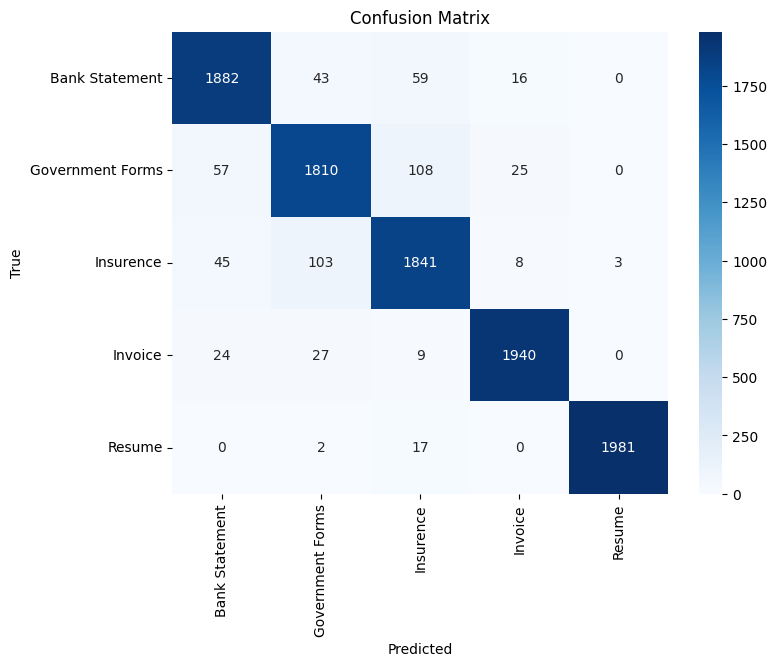

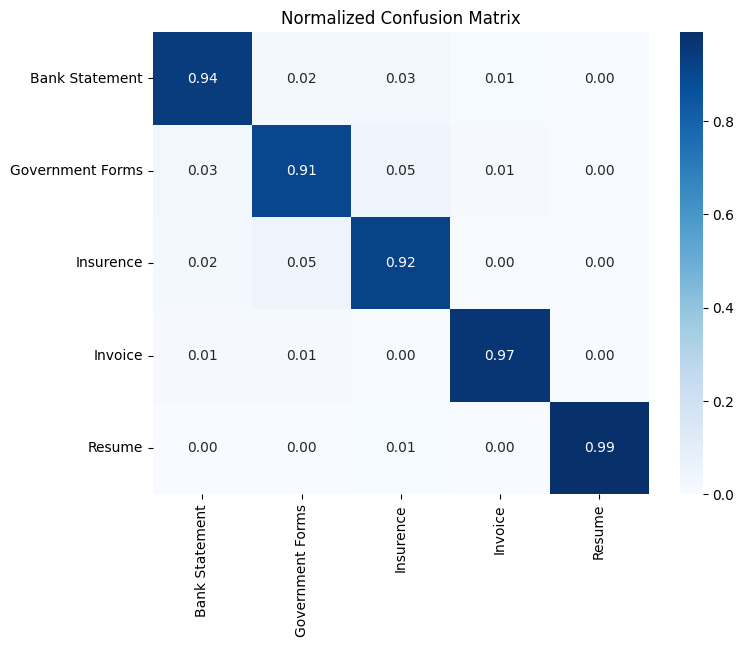

Classification Report:

                  precision    recall  f1-score   support

  Bank Statement       0.94      0.94      0.94      2000
Government Forms       0.91      0.91      0.91      2000
       Insurence       0.91      0.92      0.91      2000
         Invoice       0.98      0.97      0.97      2000
          Resume       1.00      0.99      0.99      2000

        accuracy                           0.95     10000
       macro avg       0.95      0.95      0.95     10000
    weighted avg       0.95      0.95      0.95     10000



In [9]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Normalized Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [10]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "num_classes": 5,
    "model_name": "vit_7b_patch16_dinov3"
}, "model1.pth")


In [11]:
model.eval()
correct = 0
total = 0
print("test")
with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total

print(
    f"Epoch [{epoch+1}/5] | "
    f"Train Loss: {train_loss:.4f} | "
    f"Test Acc: {test_acc:.2f}%"
)


test
Epoch [6/5] | Train Loss: 0.0231 | Test Acc: 94.54%
